In [30]:
import argparse
import time
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from unet import ResidualUNet, Denoiser
from utils import save_image, dotdict
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

In [131]:
class DDPM:
    def __init__(self, model, timesteps=1000, beta_start=0.0001, beta_end=0.02, n_skip = 0, lr = 2e-4):
        self.model = model
        self.timesteps = timesteps-n_skip
        self.reversed_time_steps = torch.arange(self.timesteps-1,-1,-1)
        #print(self.reversed_time_steps)
        self.betas = torch.linspace(beta_start, beta_end, timesteps, dtype=torch.float32, device=device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        
        self.alphas = self.alphas[n_skip:]
        self.betas = self.betas[n_skip:]
        self.alphas_cumprod = self.alphas_cumprod[n_skip:]
        self.lr = lr
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        print(self.alphas_cumprod)

    def forward(self,data, model, alphasb_batch = None):
        im = data
    
        # parameters of the langevin dynamics steps
        ind_randoms= torch.randint(0, self.timesteps, (data.shape[0],), device = data.device)
        
        noise_in = torch.randn_like(im)
        if alphasb_batch is None:
            alphasb_batch = self.alphas_cumprod[ind_randoms]
    
            im_input = (torch.sqrt(1-alphasb_batch)[:,None,None,None]*noise_in+torch.sqrt(alphasb_batch)[:,None,None,None]*im)
        else :
            im_input = im
        
        pred_eps = model(im_input, alphasb_batch)
        score = -pred_eps/torch.sqrt(1-alphasb_batch)[:,None,None,None]
        # corrected image 
        im_corrected = (im_input-torch.sqrt(1-alphasb_batch)[:,None,None,None]*pred_eps)/torch.sqrt(alphasb_batch)[:,None,None,None]
    
        square_norm = torch.sum((pred_eps-noise_in)**2,(1,2,3)) # square norm of loss per image
        loss = square_norm.sum()
        return loss, im_input, im_corrected, pred_eps, score
                

    def sample_sde(self, num_samples, shape=(3,64,64), corr = True):
        with torch.no_grad():  # avoid backprop wrt model parameters
            x = torch.randn((num_samples,)+shape, dtype=torch.float32, device=device)
            for i, t in enumerate(self.reversed_time_steps):
                
                t_tensor = torch.tensor(t, device=x.device).repeat(num_samples)
                alphasb_batch = self.alphas_cumprod[t_tensor]
                loss, im_input, im_corrected, eps, score= self.forward(x, self.model, alphasb_batch)

                alpha_t = self.alphas[t]
                alpha_t_cumprod = self.alphas_cumprod[t]
                beta_t = self.betas[t]

                mean = 1/(torch.sqrt(alpha_t))*(x-(beta_t/torch.sqrt(1-alpha_t_cumprod))*eps)
                

                noise = torch.randn_like(x)
                x = mean + torch.sqrt(beta_t) * noise
                if t==0 and corr:
                    print("last corr")
                    x = im_corrected
        return x

    def sample_sde_masked(self,  y,mask, num_samples, shape=(3,64,64), corr = True):
        with torch.no_grad():  # avoid backprop wrt model parameters
            x = torch.randn((num_samples,)+shape, dtype=torch.float32, device=device)
            for i, t in enumerate(self.reversed_time_steps):
                
                t_tensor = torch.tensor(t, device=x.device).repeat(num_samples)
                alphasb_batch = self.alphas_cumprod[t_tensor]
                x = mask*self.add_noise(y,t_tensor)+x*(1.0-mask)
                loss, im_input, im_corrected, eps, score= self.forward(x, self.model, alphasb_batch)
                alpha_t = self.alphas[t]
                alpha_t_cumprod = self.alphas_cumprod[t]
                beta_t = self.betas[t]

                mean = 1/(torch.sqrt(alpha_t))*(x+beta_t*score)

                noise = torch.randn_like(x)
                x = mean + torch.sqrt(beta_t) * noise
                
                if t==0 and corr:
                    print("last corr")
                    x = im_corrected
        return x

    def sample_ode(self, num_samples, shape=(3,64,64), corr = True):
        with torch.no_grad(): # avoid backprop wrt model parameters
            x = torch.randn((num_samples,)+shape, dtype=torch.float32, device=device)
            for i, t in enumerate(self.reversed_time_steps):
                
                #TODO
                t_tensor = torch.tensor(t, device=x.device).repeat(num_samples)
                x = self.ode_step(x,t_tensor)
        return x
        
    def ode_step(self, x, t_tensor, corr = True):
        with torch.no_grad():
            alphasb_batch = self.alphas_cumprod[t_tensor]
            loss, im_input, im_corrected, pred_eps, score= self.forward(x, self.model, alphasb_batch)
            beta_t = self.betas[t_tensor]
            xip = (2-torch.sqrt(1-beta_t))[:,None,None,None]*x+1/2*beta_t[:,None,None,None]*score
            x = xip# + torch.sqrt(beta_t)*noise
            if corr:
                x = torch.where((t_tensor==0)[:,None,None,None],im_corrected,x)
        return x
    

    def load(self, path):
        """Load the model's state from a file."""
        self.model.load_state_dict(torch.load(path, map_location=next(model.parameters()).device))

    def store(self, path):
        """Store the model's state to a file."""
        torch.save(self.model.state_dict(), path)

    def add_noise(self,batch,t_tensor):
        noise = torch.randn_like(batch, dtype=torch.float32)
        noisy_data = torch.sqrt(self.alphas_cumprod[t_tensor]).view(-1, 1,1,1) * batch + torch.sqrt(1.0 - self.alphas_cumprod[t_tensor]).view(-1, 1,1,1) * noise
        return noisy_data

    def train(self, dataloader, epochs=1000, batch_size=64, warmup=True):
        criterion = nn.MSELoss()
        
        losses = []
        mean_loss = 0
        i = 0
        if warmup:
            for param_group in self.optimizer.param_groups:
                param_group['lr'] = 0.0
        for epoch in range(epochs):
            for x, idx in tqdm(dataloader):
                x = x.to(device)
                self.optimizer.zero_grad()
                loss, im_input, im_corrected, pred_eps, score= self.forward(x, self.model)
                mean_loss+=loss.item()
                i+=1
                loss.backward()
                self.optimizer.step()

            if epoch % 1 == 0:
                losses.append(mean_loss/i)
                print(f'Epoch {epoch}, Loss: {mean_loss/i}')
                mean_loss = 0
                i = 0
            if epoch==1 and warmup:
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = self.lr
        return losses
    


In [106]:

TEST = False# set to true to load model from disk and only generate to test langevin

# Training settings
args_dict = {'batch_size' : 64, 'test_batch_size' :64, 'epochs' :1000, 'lr' : 0.0002, 'gamma' : 0.995, 'no_cuda' :False, 
             'dry_run':False, 'seed': 1, 'log_interval' : 200, 'save_model' :True, 'only_test':False, 'model_path':"models/denoiserceleba.pt", 
             'load_model_from_disk':True, 'dataset':"CELEBA", 'test':False}
args = dotdict(args_dict)
#parser = argparse.ArgumentParser(description="A simple argument parser example.")

# Add arguments
#parser.add_argument('--dataset', type=str, required=False, default = 'MNIST', help='Dataset can be one of MNIST, CIFAR, CELEBA')
#parser.add_argument('--test', type= str, required = False, help='wether to only test a model, requires path to the testing weights')

# Parse the arguments
#margs = parser.parse_args()
#args.dataset = margs.dataset
#if margs.test is not None:
#    print("TEST")
#    args.test = True
#    print(args.test)
#    args.model_path = margs.test

if args.test:
    print("TEST")
    args.load_model_from_disk = True
    args.only_test = True
use_cuda = not args.no_cuda and torch.cuda.is_available()

torch.manual_seed(args.seed)

if use_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

train_kwargs = {'batch_size': args.batch_size}
test_kwargs = {'batch_size': args.test_batch_size}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

dataset = args.dataset
if dataset == "CIFAR":
    transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),#mean, std
    transforms.RandomHorizontalFlip(p=0.5)
    ])

    dataset1 = datasets.CIFAR10(root='./data/cifar10', train=True, download=True, transform=transform)
    dataset2 = datasets.CIFAR10(root='./data/cifar10', train=False, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
    model = Denoiser(4,3).to(device)
elif dataset == "CELEBA":
    transform = transforms.Compose([transforms.Resize((64,64)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                    std=[0.5, 0.5, 0.5])])
    dataset1 = datasets.CelebA("../data/celeba", split = 'train',download=False, transform=transform)
    dataset2 = datasets.CelebA("../data/celeba", split = 'test', download=False, transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
    model = Denoiser(3,3).to(device)

elif dataset=="MNIST":
    # loading dataset
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Pad(2),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    dataset1 = datasets.MNIST('./data/mnist', train=True, download=True,
    transform=transform)
    dataset2 = datasets.MNIST('./data/mnist', train=False,
    transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Denoiser(1,1).to(device)

if args.load_model_from_disk:
    model.load_state_dict(torch.load(args.model_path, weights_only= True))



In [132]:
#ddpm.train(train_loader, epochs=40)
import numpy as np
ddpm = DDPM(model, timesteps=1000, beta_start = 1e-4, beta_end = 0.02, n_skip=50)


tensor([9.6995e-01, 9.6887e-01, 9.6777e-01, 9.6665e-01, 9.6551e-01, 9.6436e-01,
        9.6319e-01, 9.6200e-01, 9.6079e-01, 9.5956e-01, 9.5832e-01, 9.5706e-01,
        9.5578e-01, 9.5449e-01, 9.5318e-01, 9.5185e-01, 9.5050e-01, 9.4914e-01,
        9.4776e-01, 9.4636e-01, 9.4494e-01, 9.4351e-01, 9.4207e-01, 9.4060e-01,
        9.3912e-01, 9.3762e-01, 9.3611e-01, 9.3458e-01, 9.3304e-01, 9.3147e-01,
        9.2990e-01, 9.2830e-01, 9.2669e-01, 9.2507e-01, 9.2343e-01, 9.2177e-01,
        9.2010e-01, 9.1841e-01, 9.1671e-01, 9.1500e-01, 9.1326e-01, 9.1152e-01,
        9.0976e-01, 9.0798e-01, 9.0619e-01, 9.0438e-01, 9.0256e-01, 9.0073e-01,
        8.9888e-01, 8.9702e-01, 8.9514e-01, 8.9325e-01, 8.9135e-01, 8.8943e-01,
        8.8750e-01, 8.8555e-01, 8.8359e-01, 8.8162e-01, 8.7964e-01, 8.7764e-01,
        8.7563e-01, 8.7360e-01, 8.7157e-01, 8.6952e-01, 8.6746e-01, 8.6538e-01,
        8.6330e-01, 8.6120e-01, 8.5909e-01, 8.5697e-01, 8.5483e-01, 8.5269e-01,
        8.5053e-01, 8.4836e-01, 8.4618e-

In [133]:
def plot_mnist_batch(images_tensor):
    # Move the tensor to CPU and convert to NumPy
    n_images = images_tensor.shape[0]
    images_cpu = torch.clip(images_tensor,0,1).cpu().numpy()

    # Determine the number of rows and columns for the plot
    n_rows = int(np.ceil(np.sqrt(n_images)))
    n_cols = int(np.ceil(n_images / n_rows))

    # Create a figure with the calculated number of rows and columns
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12,12))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Plot each image
    for i in range(n_images):
        ax = axes[i]
        ax.imshow(np.transpose(images_cpu[i], (1, 2, 0)), cmap='gray')
        ax.axis('off')

    # Hide any empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

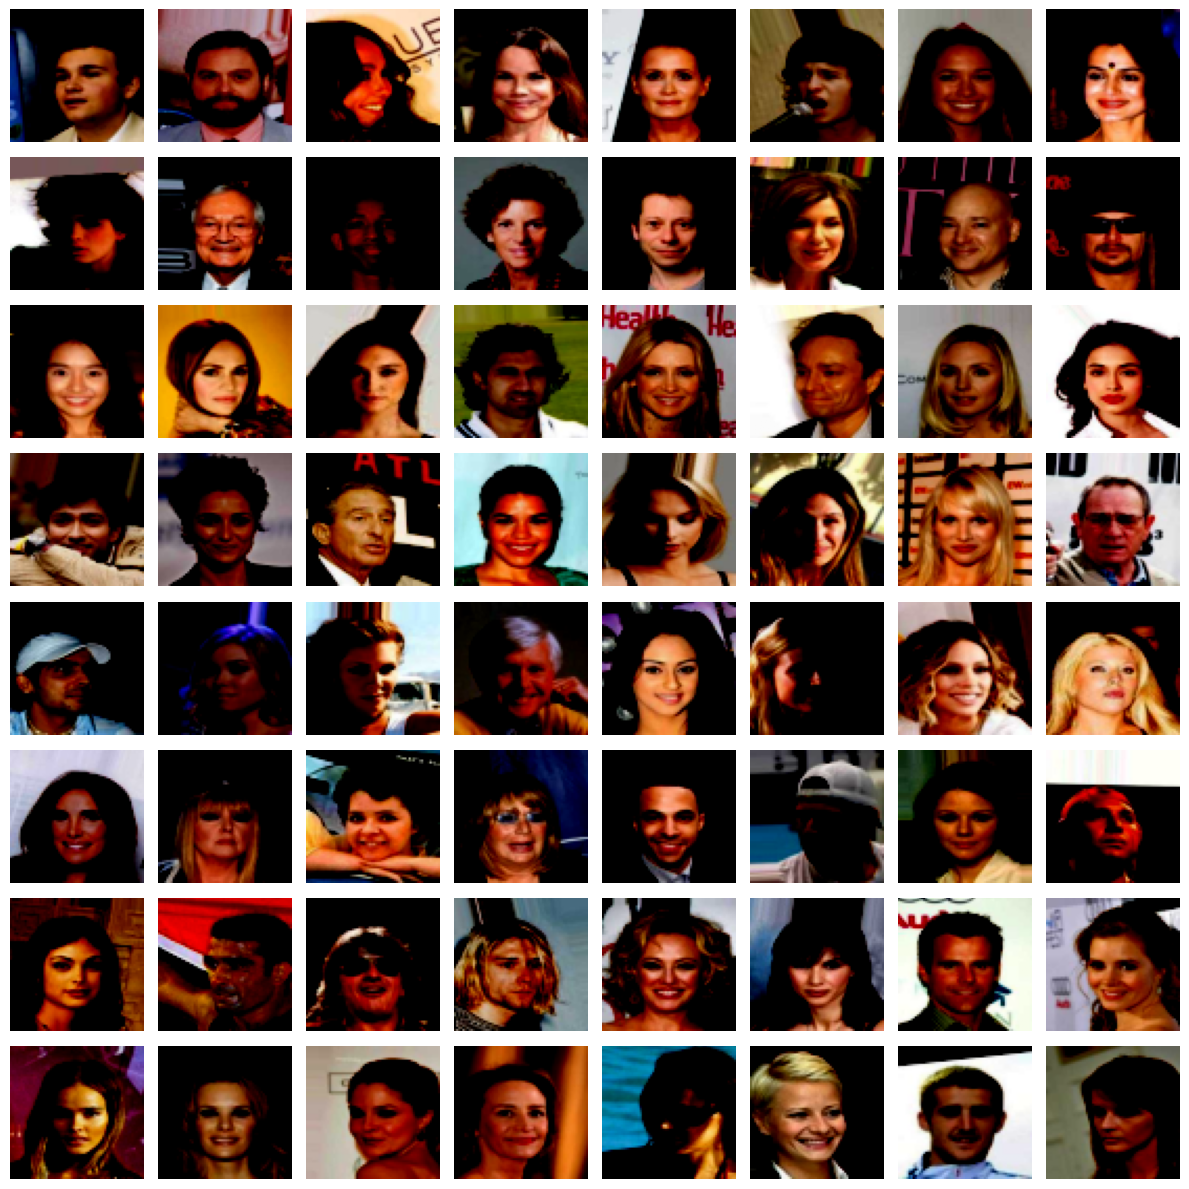

In [167]:
im, labels = next(iter(train_loader))
plot_mnist_batch(im)


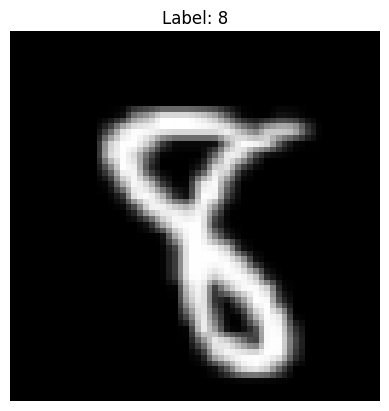

In [168]:
# Define the transformation for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Resize((64, 64), interpolation=transforms.InterpolationMode.BILINEAR),
])

# Load the MNIST dataset
dataset = datasets.MNIST('./data/mnist', train=True, download=True, transform=transform)

# Create a DataLoader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

# Get a single batch from the DataLoader
images, labels = next(iter(data_loader))

# Since batch_size is 1, we can directly access the first (and only) image in the batch
image = images[0].squeeze()  # Remove the channel dimension for visualization
label = labels[0].item()

# Plot the image
plt.imshow(image, cmap='gray')
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

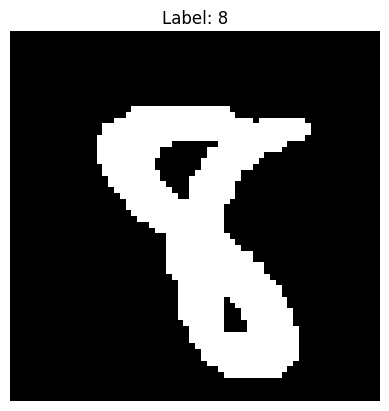

In [169]:
mask_digit = (image>0).float()
# Plot the image
plt.imshow(mask_digit, cmap='gray')
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

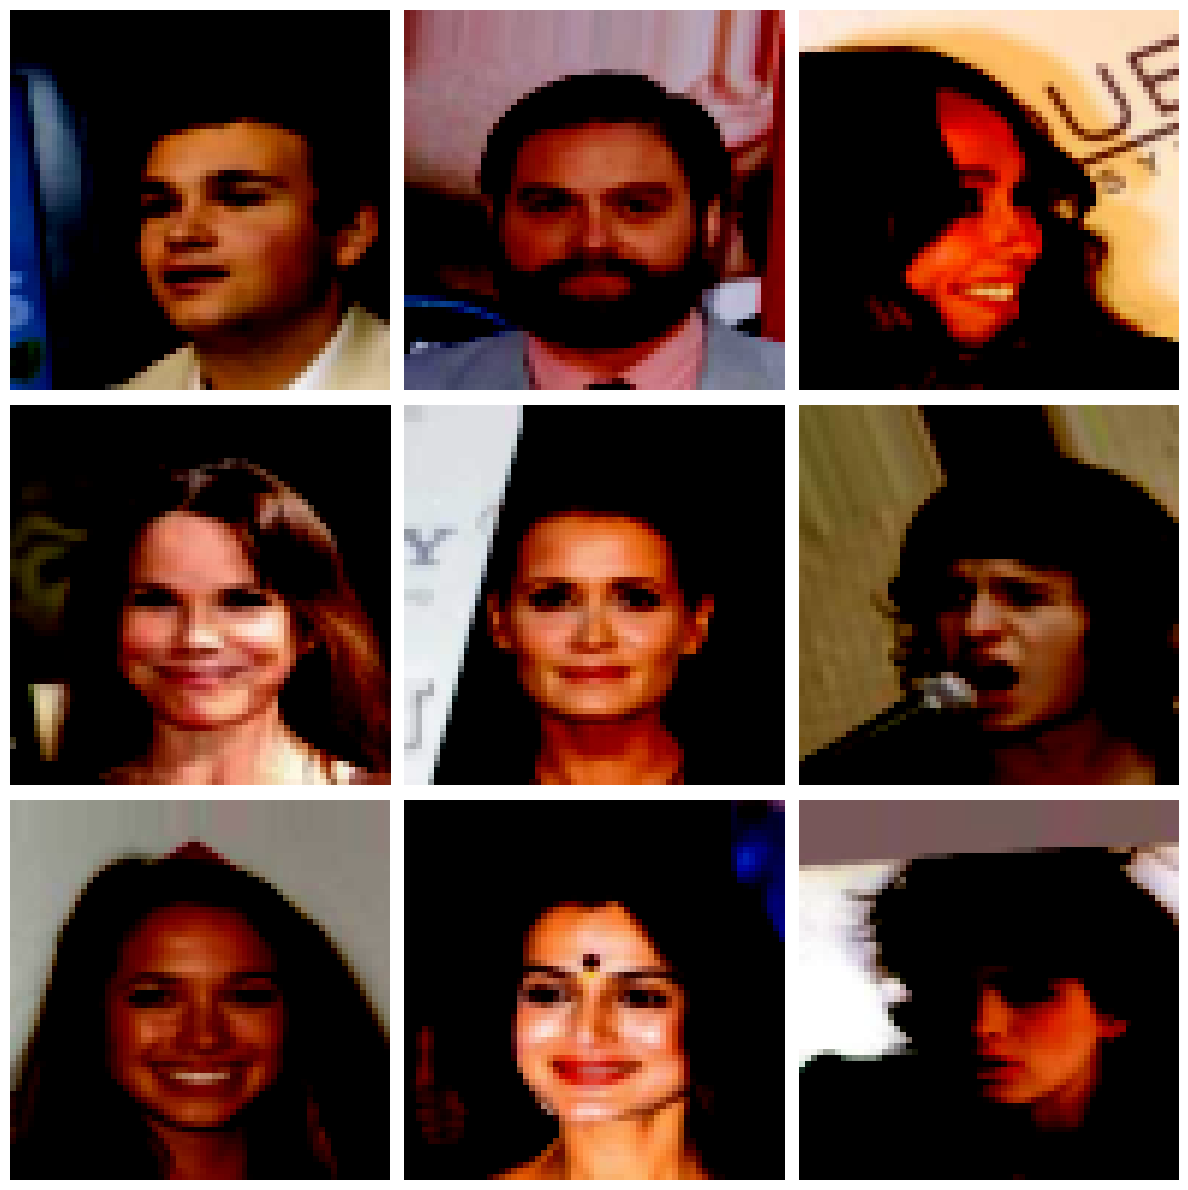

/tmp/ipykernel_68847/660686222.py:70: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_tensor = torch.tensor(t, device=x.device).repeat(num_samples)


last corr


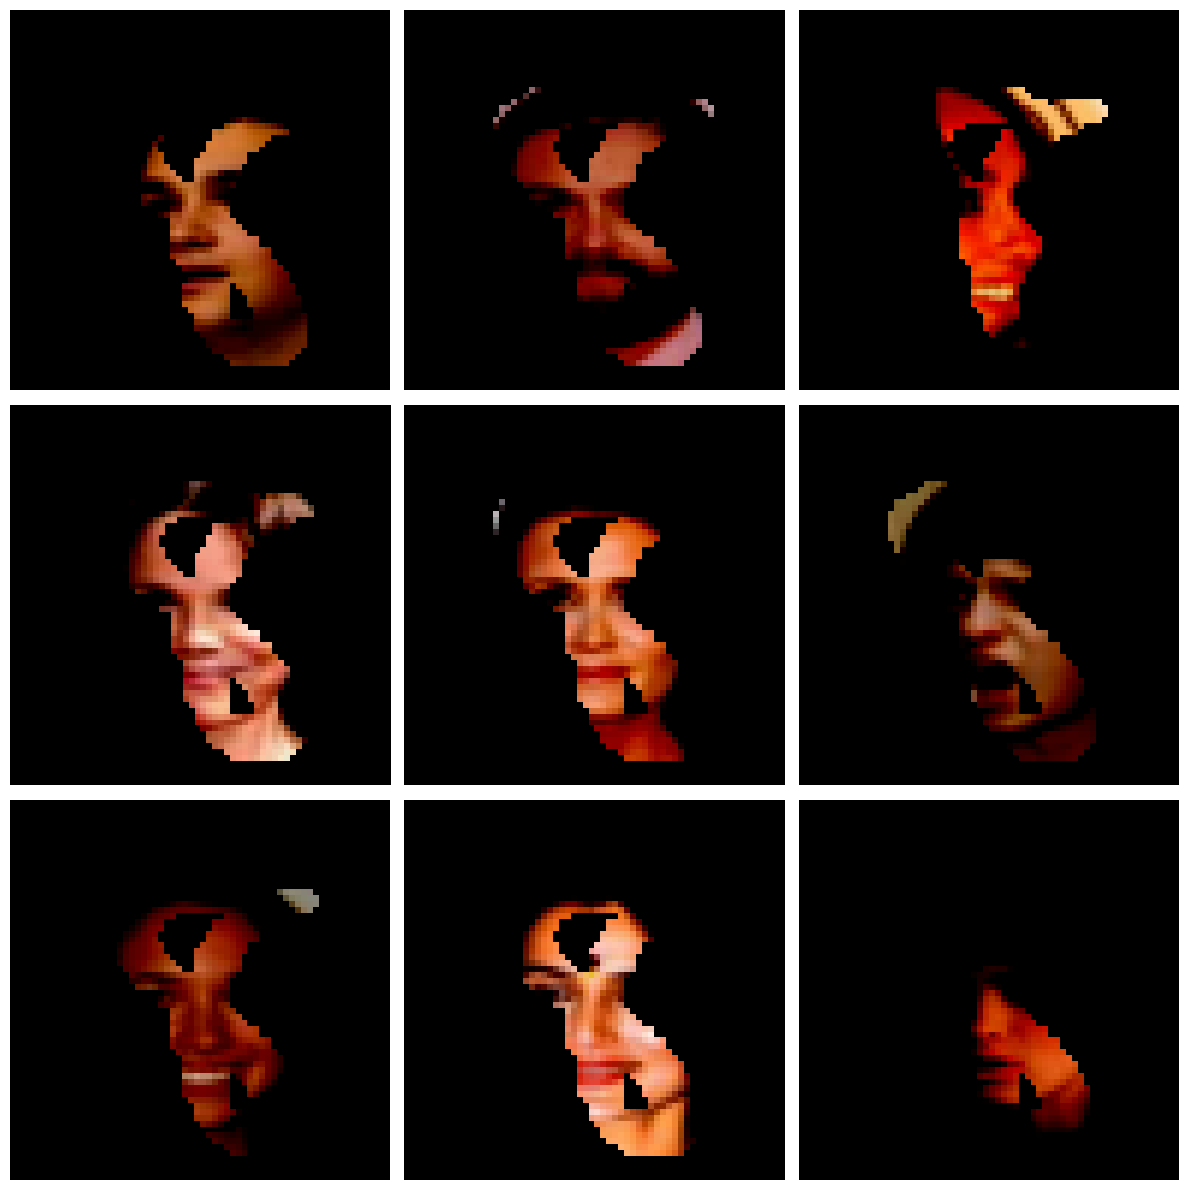

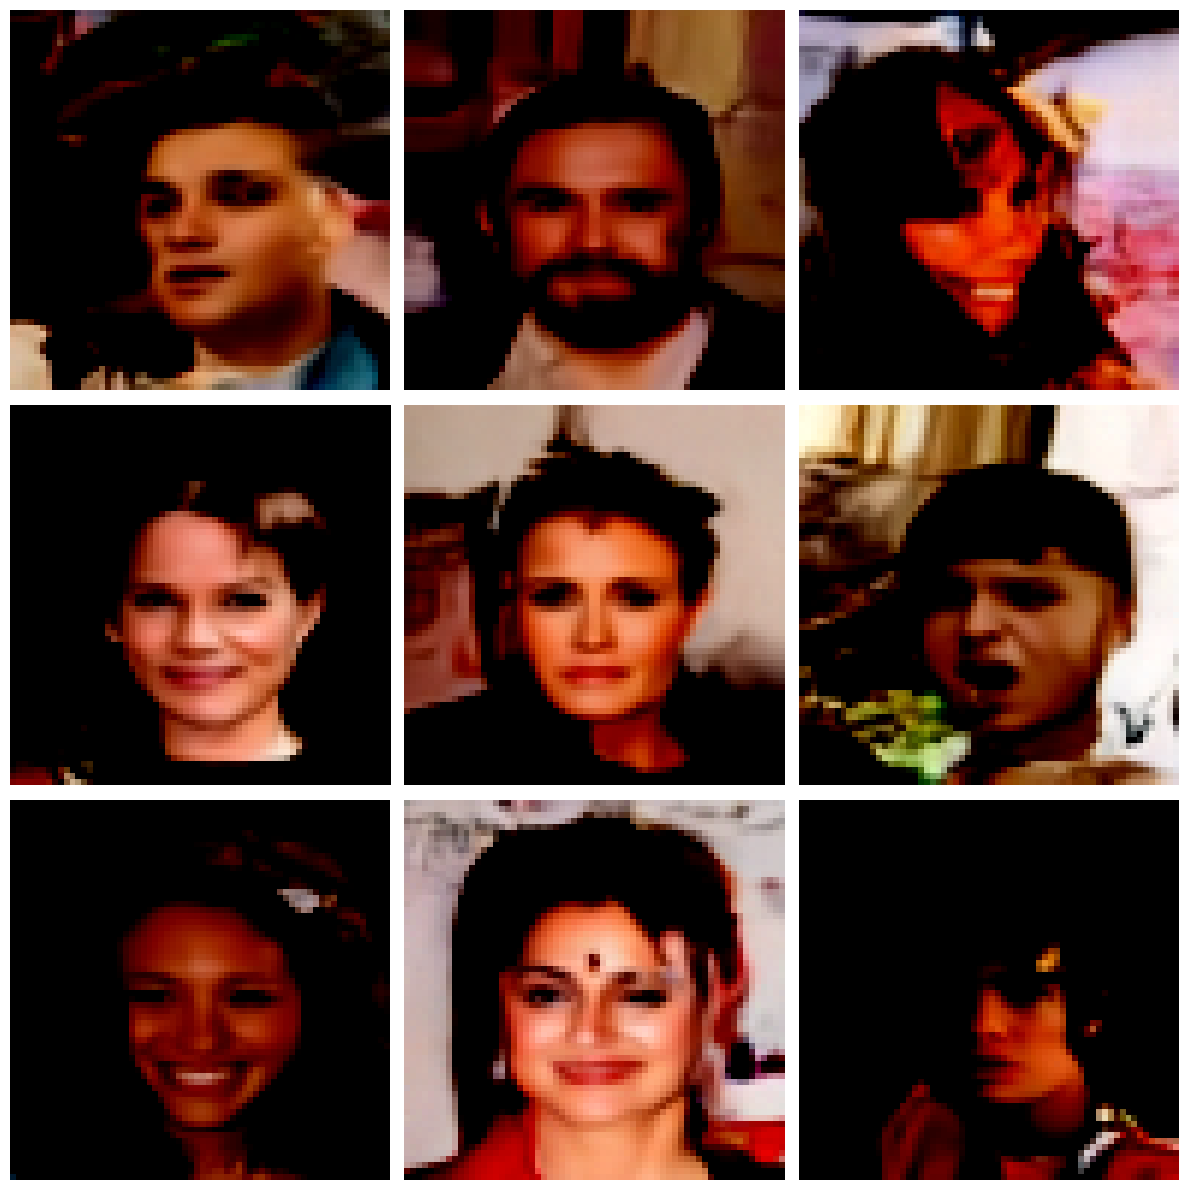

In [171]:
im_ref= im[:9].to(device)
plot_mnist_batch(im_ref)
mask = torch.tril(torch.ones((64,64), device=device))[None,None,:,:]

mask = mask_digit.to(device)
im_ref_masked = im_ref*mask
im_sample = ddpm.sample_sde_masked(im_ref.to(device),mask ,9)
plot_mnist_batch(im_ref_masked)
plot_mnist_batch(im_sample)

In [110]:
images_ode = ddpm.sample_ode(64, solver = "heun")
images_sde = ddpm.sample_sde(64)
#images_corr = ddpm.sample_sde(64, corr=False)

TypeError: DDPM.sample_ode() got an unexpected keyword argument 'solver'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

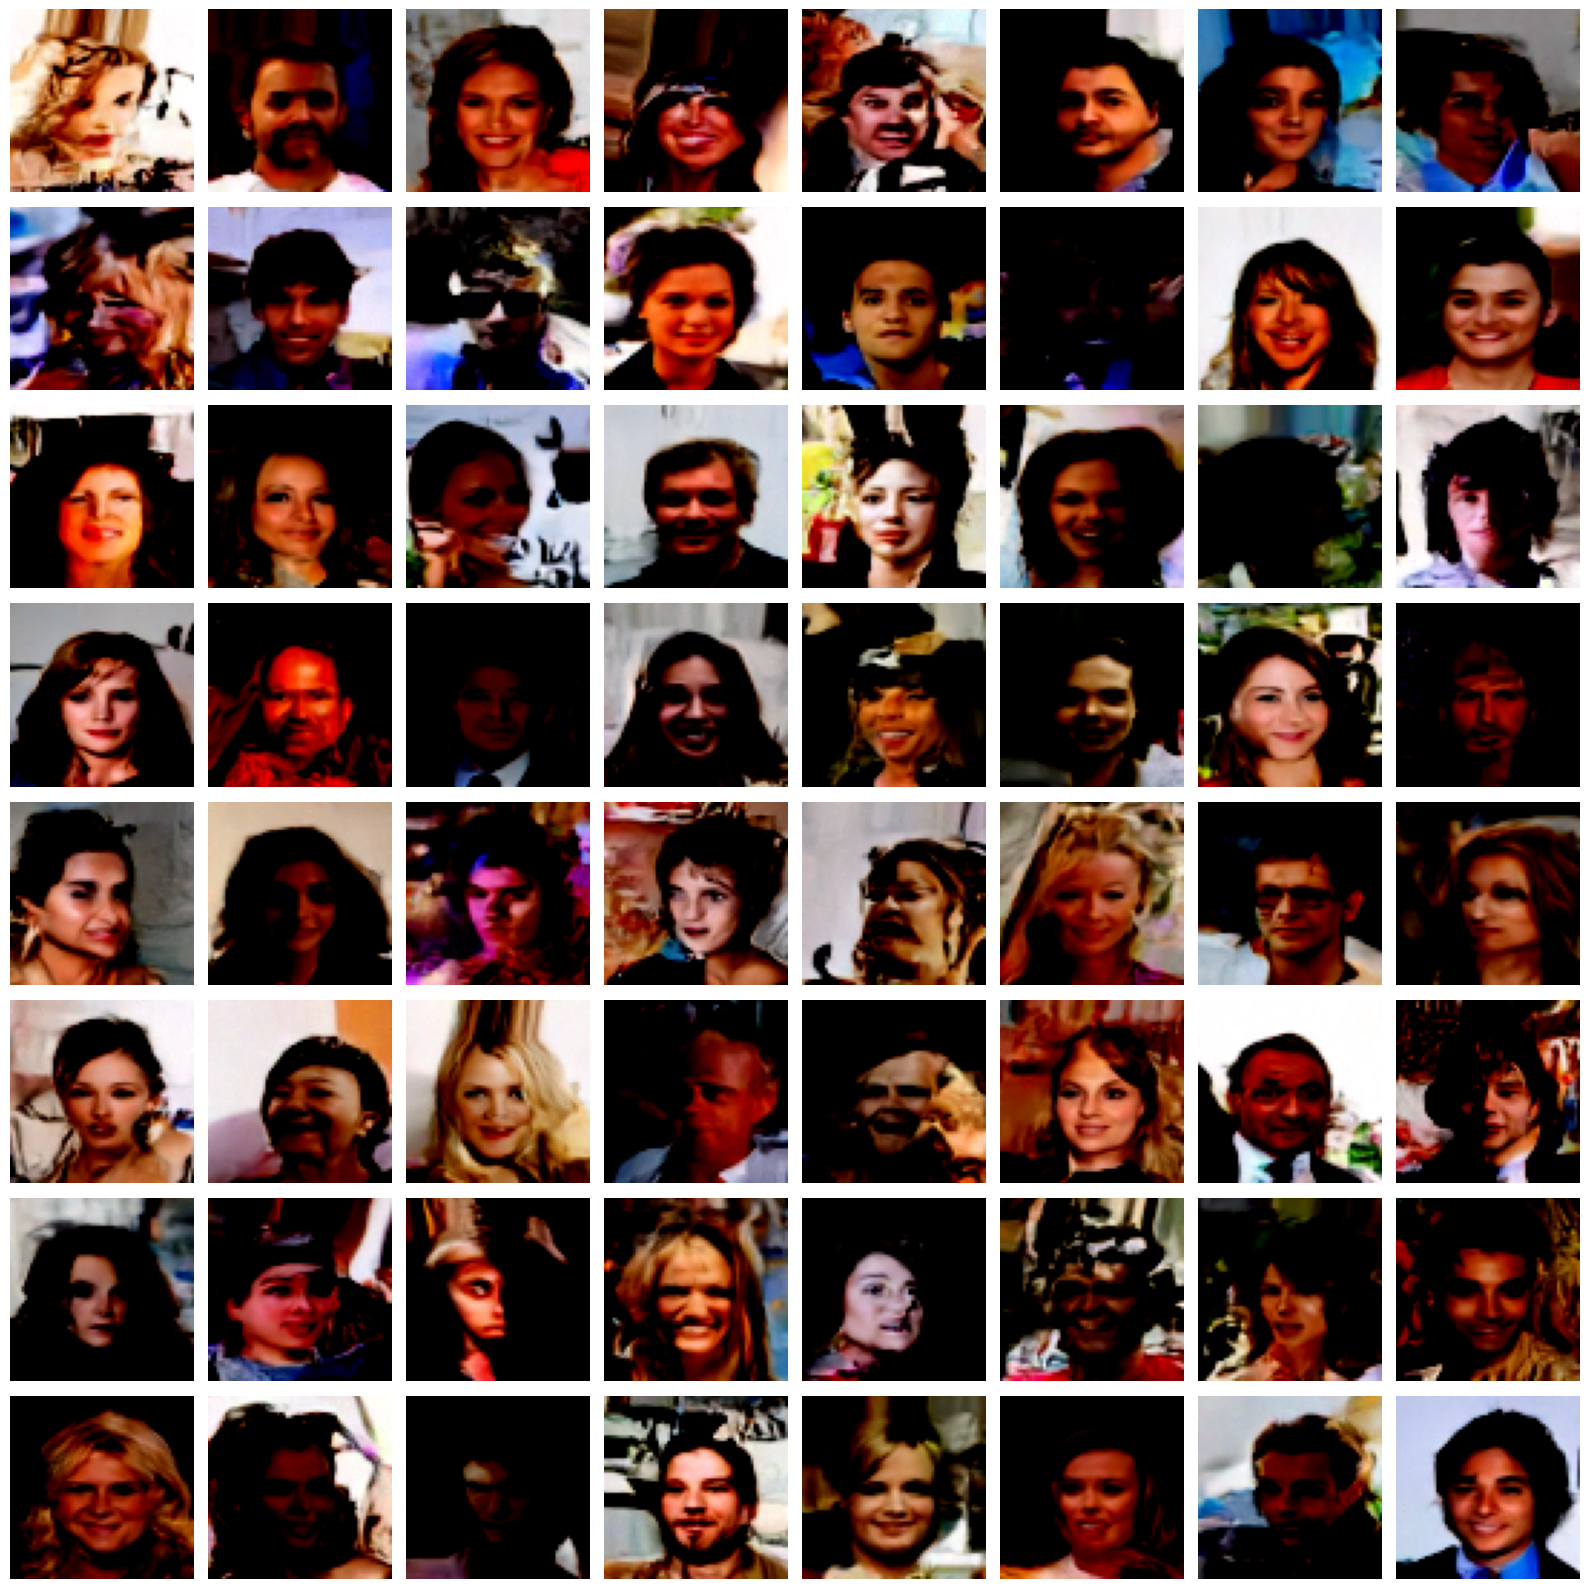

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

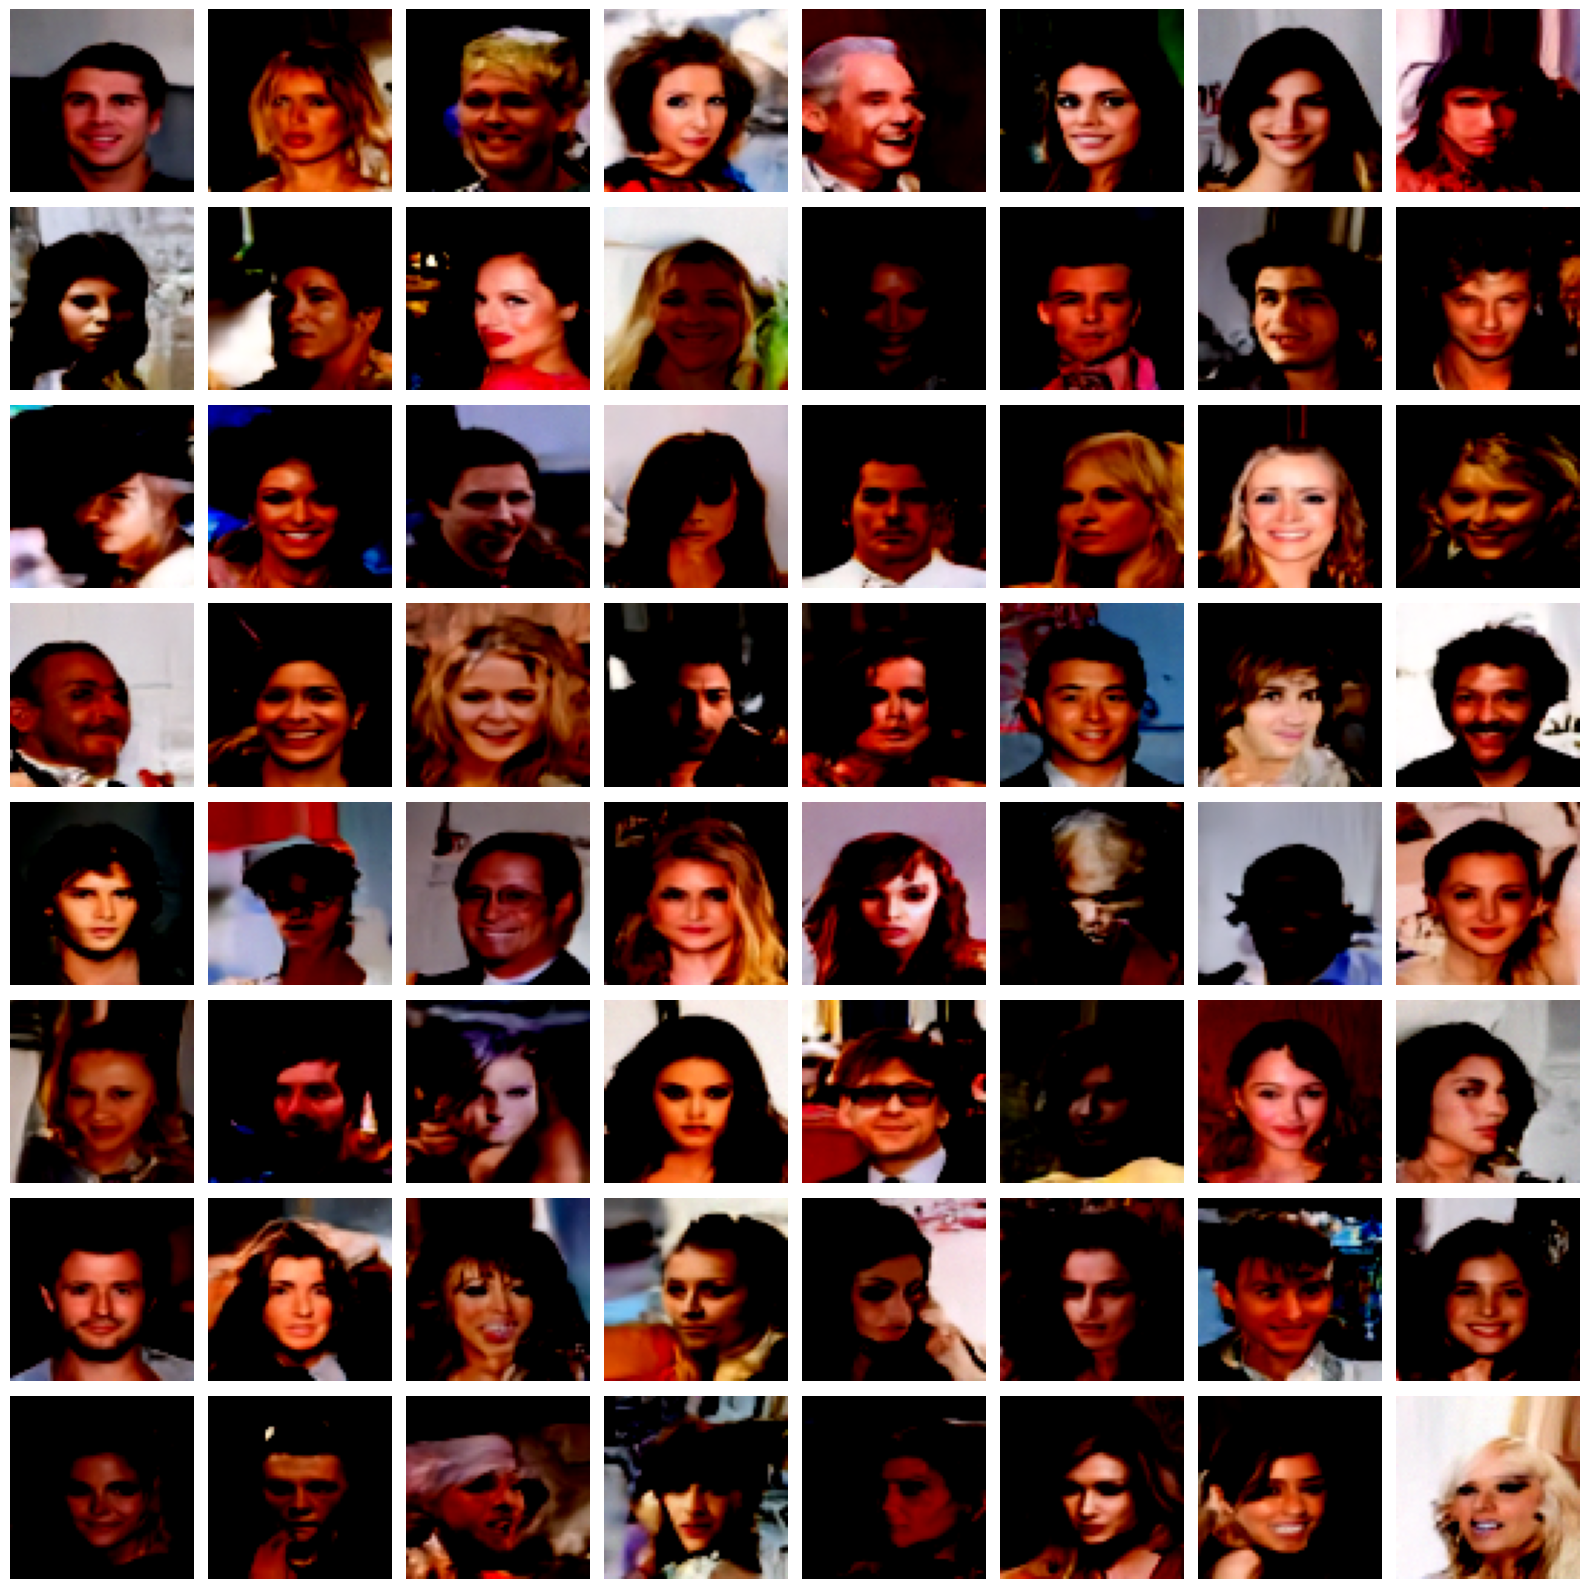

In [59]:
plot_mnist_batch(images_ode)
plot_mnist_batch(images_sde)

In [28]:
import copy
from tqdm import tqdm
class ConsistencyModel:
    def __init__(self, student_model, teacher_model, learning_rate=2e-4, mu=0.95):
        self.student_model = student_model  # Consistency model
        self.teacher_model = teacher_model  # Pretrained DDPM model
        self.timesteps =  teacher_model.timesteps
        self.learning_rate = learning_rate
        self.mu = mu  # EMA parameter
        self.optimizer = optim.Adam(self.student_model.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()
        
        self.theta_minus_model = self.create_ema_model()
    
    def create_ema_model(self):
        """ Create a copy of the student model for EMA tracking """
        ema_model = copy.deepcopy(self.student_model)
        for param in ema_model.parameters():
            param.requires_grad = False  # Freeze EMA model
        return ema_model.to(device)
    
    def update_ema(self):
        """ Exponential Moving Average (EMA) update for θ⁻ """
        with torch.no_grad():
            for param, param_ema in zip(self.student_model.parameters(), self.theta_minus_model.parameters()):
                param_ema.data = self.mu * param_ema.data + (1 - self.mu) * param.data

    def sample(self,num_samples, im_shape):
        x = torch.randn((num_samples,)+im_shape, dtype=torch.float32, device=device)
        with torch.no_grad():
            return self.student_model(x, self.teacher_model.alphas_cumprod[-1]*torch.ones((num_samples,), device = device))
        
        
    def load(self, path):
        """Load the model's state from a file."""
        self.student_model.load_state_dict(torch.load(path, map_location=next(student_model.parameters()).device))

    def store(self, path):
        """Store the model's state to a file."""
        torch.save(self.student_model.state_dict(), path)

    def train(self, train_loader, test_loader, epochs=100, batch_size=64):
        for epoch in range(epochs):
            epoch_loss = 0
            i=0
            for x,label in tqdm(train_loader):
                i+=1
                x = x.to(device)
                self.optimizer.zero_grad()
                
                # Sample t_n and t_{n+1}
                n = torch.randint(0, self.timesteps - 2, (x.size(0),), device=x.device)
                t_n = n   # Select t_n
                
                t_np1 = t_n+1  # Select t_n+1
                
                # Sample x_{t_{n+1}}
                #noise = torch.randn_like(x, device=x.device)
                
                x_tnp1 = self.teacher_model.add_noise(x, t_np1)
                alphas_cumprod_t = self.teacher_model.alphas_cumprod[t_n]
                alphas_cumprod_tp1 = self.teacher_model.alphas_cumprod[t_np1]
                
                # Compute teacher output (ODE solver)
                with torch.no_grad():
                    x_hat_tn = self.teacher_model.ode_step(x_tnp1, t_np1)
                    #x_hat_phi_tn = x_tnp1 - t_np1.view(-1, 1) * (t_n.view(-1, 1) - t_np1.view(-1, 1)) * phi_tn
                
                # Compute student output
                student_output = self.student_model(x_tnp1, alphas_cumprod_tp1)
                
                with torch.no_grad():  # Stop gradient flow
                    theta_minus_output = torch.where((t_n==0)[:,None,None,None],x,self.theta_minus_model(x_hat_tn, alphas_cumprod_t))
                    #theta_minus_output=self.teacher_model.add_noise(x,t_n)
                
                # Compute loss
                loss = self.loss_fn(student_output, theta_minus_output)
                loss.backward()
                self.optimizer.step()
                
                # EMA update
                if i%1==0:
                    self.update_ema()
                
                epoch_loss += loss.item()
        
            print(f"Epoch {epoch}, Loss: {epoch_loss / len(train_loader)}")
            # Evaluate on test set every 2 epochs
            if epoch % 1 == 0:
                test_loss = 0
                with torch.no_grad():
                    for x, label in tqdm(test_loader):
                        x = x.to(device)
                        n = torch.randint(0, self.timesteps - 2, (x.size(0),), device=x.device)
                        t_n = n
                        t_np1 = t_n + 1
                        x_tnp1 = self.teacher_model.add_noise(x, t_np1)
                        alphas_cumprod_t = self.teacher_model.alphas_cumprod[t_n]
                        student_output = self.student_model(x_tnp1, alphas_cumprod_t)
                        theta_minus_output = self.theta_minus_model(x_tnp1, alphas_cumprod_t)
                        loss = self.loss_fn(student_output, theta_minus_output)
                        test_loss += loss.item()
                images = self.sample(64,(1,32,32))
                plot_mnist_batch(images)
        
                avg_test_loss = test_loss / len(test_loader)
                print(f"Epoch {epoch}, Test Loss: {avg_test_loss}")
        return self.student_model

In [29]:

student_model = Denoiser(1,1).to(device)
student_model.load_state_dict(model.state_dict())


<All keys matched successfully>

In [30]:
consistency_model = ConsistencyModel(student_model, ddpm)

In [ ]:

student_model = consistency_model.train(train_loader, test_loader, epochs=100, batch_size=64)

 23%|██████▋                      | 216/938 [00:23<01:17,  9.35it/s]

In [ ]:
x, label = next(iter(train_loader))

In [ ]:
x = x.to(device)


In [ ]:
plot_mnist_batch(x)